# Nudging

We will use a multi-armed bandit algorithm. We have 8 bandits (one for each persona), with 3 arms each one (Story-telling, Peers Comparison, Framing). The reward is +1 if we choose the correct arm, 0 in the other case. We run a first round to initialize all the arms for each bandit. We joined and uniformly shuffled the three datasets and used only the rows with ones. We use two different algorithms.

In [1]:
#Import libraries

import scipy.io
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load

mat = scipy.io.loadmat('NudgingContents.mat') 

#Preprocessing

X_ST=pd.DataFrame(mat['X_ST'], columns = ['x','a','b','c'])
y_ST=pd.DataFrame(mat['y_ST'], columns = ['y'])
ST=pd.concat([X_ST.iloc[:,0],y_ST], axis=1)

X_PC=pd.DataFrame(mat['X_PC'], columns = ['x','a','b','c'])
y_PC=pd.DataFrame(mat['y_PC'], columns = ['y'])
PC=pd.concat([X_PC.iloc[:,0],y_PC], axis=1)

X_FR=pd.DataFrame(mat['X_FR'], columns = ['x','a','b','c'])
y_FR=pd.DataFrame(mat['y_FR'], columns = ['y'])
FR=pd.concat([X_FR.iloc[:,0],y_FR], axis=1)

# Personas = pd.DataFrame(mat['Personas'], 
#                         columns = ['age {0 if <42, 1 if >= 42 }','gender {0 = F, 1 = M}','education {0 = low, 1 = high}'], 
#                         index = [i for i in range(1,9)])

ST = ST[ST.y==1]
PC = PC[PC.y==1]
FR = FR[FR.y==1]

ST.y *= 0
PC.y *= 1
FR.y *= 2

# Final Dataset

df = pd.concat([ST,PC,FR])
df.columns = ['Persona', 'Arm'] # Arm: 0-ST, 1-PC, 2-FR
df = df.sample(frac = 1, random_state = 42).reset_index().drop(columns = ['index'])

df_copy = df

## Multi-armed Bandits with Thompson sampling

Firstly, we made some assumptions:

1) each i-th arm for the j-th persona has a "true"-reward with stationary distribution (although there are also modified versions which don't require this assumption);

2) each "true"-reward is $R_{ij} \sim Be(p_{ij})$;

3) we have no prior information on which arm to choose (or we will choose the one with the highest probability of reward...), so we modelize the prior associated to each arm as a $X_{ij} \sim Beta(1,1)$;

4) each observation is iid respect to the others.

The algorithm works as follow (assume that we are only considering the j-th persona):

1) simulate a random Beta from the prior distribution of each arm;

2) choose to pull the arm which has obtained the highest score;

3) observe the result (realization of $R_{ij}$, called $r_{ij}$);

4) update the posterior (which becomes the next prior) of the arm pulled and update the reward (+1 if correct, else +0). To update the posterior use the fact that in our case:

$$p(X_{ij}|r_{ij}) \propto p(r_{ij}|X_{ij})p(X_{ij})$$

so if $X_{ij} \sim Beta(\alpha_{ij}, \beta_{ij})$ then we have that:

$$X_{ij}|r_{ij} \sim Beta(\alpha_{ij} + r_{ij}, \beta_{ij} + 1 - r_{ij})$$

5) reiterate.





## Multi-armed Bandits with Confidence based selection

Idea: Don’t just look at the mean (that is, expected payoff) but also the
confidence! Then, instead of trying the action with the highest mean we can try the 
action with the highest upper bound on its confidence interval (optimistic policy). 

In [3]:
#Thompson
theta = [0,0,0] #parameters to chose the nudging for each persona

alpha = np.ones((3,8)) #alpha of every nudging
beta = np.ones((3,8)) #beta of every nudging
mean = np.zeros((3,8)) #mean of every nudging

#UCB1
mu_hat = np.ones((3,8)) # estimate of payoff per arm so far
m = np.ones((3,8))      #number of pulls per arm so far
UCB = np.zeros((3,8))  #estimated upper confidence bound per arm

rewards = [[0],[0],[0],[0],[0],[0],[0],[0]]
rewardsUCB = [[0],[0],[0],[0],[0],[0],[0],[0]]
rewards_random = [[0],[0],[0],[0],[0],[0],[0],[0]]

pullThompson = [[0],[0],[0],[0],[0],[0],[0],[0]]
pullUCB1 = [[0],[0],[0],[0],[0],[0],[0],[0]]

In [4]:
for i in range(df.shape[0]):
    persona = df.iloc[i,0] - 1 #personas
    
    #Thompson
    for arm in range(3):
        theta[arm] = scipy.stats.beta.rvs(alpha[arm,persona], beta[arm,persona], size=1)
    
    arm_pulled = theta.index(max(theta))
    random_arm = scipy.stats.randint.rvs(0,3,size=1)
    
    if df.iloc[i,1] == arm_pulled:
        alpha[arm_pulled,persona] += 1
        rewards[persona].append(rewards[persona][-1]+1)
    else:
        beta[arm_pulled,persona] += 1
        rewards[persona].append(rewards[persona][-1])
        
    #Random
    if df.iloc[i,1] == random_arm:
        rewards_random[persona].append(rewards_random[persona][-1]+1)
    else:
        rewards_random[persona].append(rewards_random[persona][-1])
        
    pullThompson[persona].append(arm_pulled) 
    mean[arm_pulled,persona] = alpha[arm_pulled,persona]/(alpha[arm_pulled,persona] + beta[arm_pulled,persona])
    
    #UCB1
    for arm in range(3):
        UCB[arm,persona] = mu_hat[arm,persona] + 0.1*np.sqrt(2*np.log(i+1)/m[arm,persona])
    
    arm_pulled = np.argmax(UCB[:,persona], axis=0)
    
    if df.iloc[i,1] == arm_pulled:
        rew = 1
        rewardsUCB[persona].append(rewardsUCB[persona][-1]+1)

    else:
        rew = 0
        rewardsUCB[persona].append(rewardsUCB[persona][-1])        
        
    m[arm_pulled,persona] += 1
    mu_hat[arm_pulled,persona] = 1/m[arm_pulled,persona]*(rew + (m[arm_pulled,persona]-1)*mu_hat[arm_pulled,persona])
    pullUCB1[persona].append(arm_pulled)

## Comparison between the random method and the multi-armed bandits solution.

A comparison between a method in which we pull randomly (uniform distribution) an arm and the multi-armed bandits. The mean reward, in the first case, thanks to the law of large number:

$$ mean\_reward_j \to \dfrac{1}{3}\sum^3_{i = 1} E[R_{ij}]$$

The multi-armed algorithm's (doing some basic Math) mean reward converges to:

$$ mean\_reward_j \to \max_{i = 1,2,3}{E[R_{ij}]}$$

and clearly:

$$\max_{i = 1,2,3}{E[R_{ij}]} \geq \dfrac{1}{3}\sum^3_{i = 1} E[R_{ij}]$$

In [5]:
for persona in range(0,8):
    i = 1
    for index in range(1,len(rewards[persona])):
        rewards[persona][index] /= i
        rewards_random[persona][index] /= i
        rewardsUCB[persona][index] /= i
        i += 1

<IPython.core.display.Javascript object>


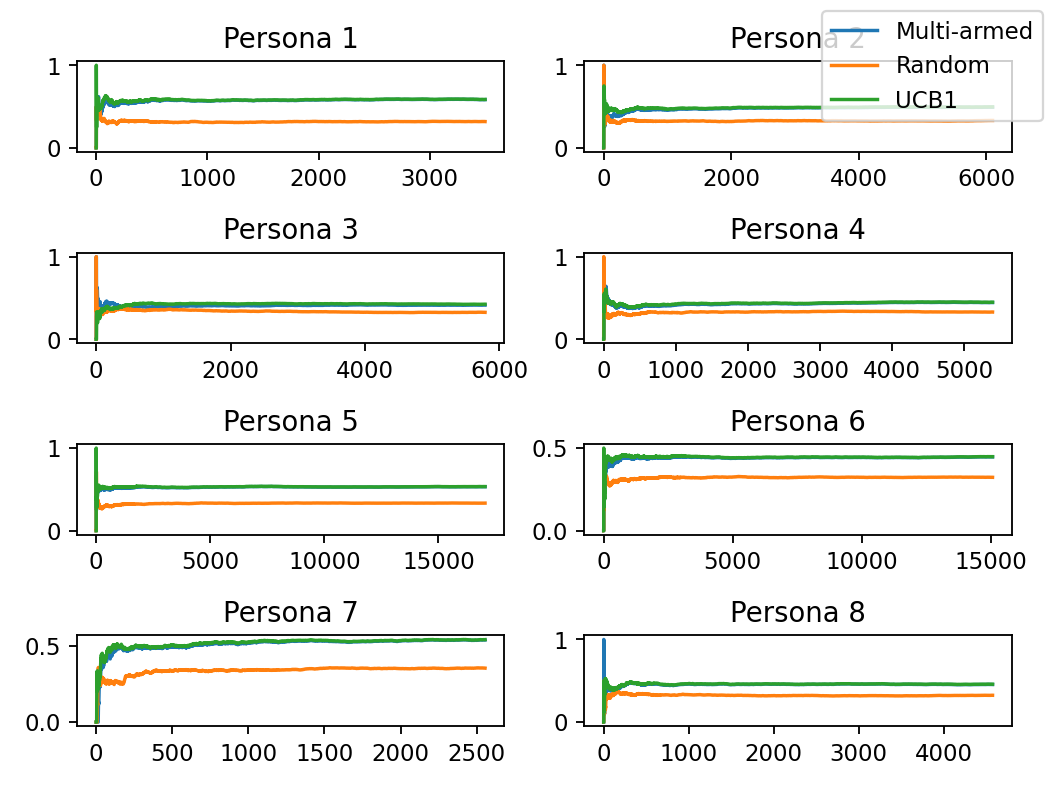

In [10]:
%matplotlib notebook

fig, axs = plt.subplots(4,2)

for i in range(0,8):
    axs[i//2, i%2].plot(rewards[i])
    axs[i//2, i%2].plot(rewards_random[i])
    axs[i//2, i%2].plot(rewardsUCB[i])
    axs[i//2, i%2].set_title('Persona ' + str(i+1))
    
fig.legend(['Multi-armed','Random','UCB1'])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


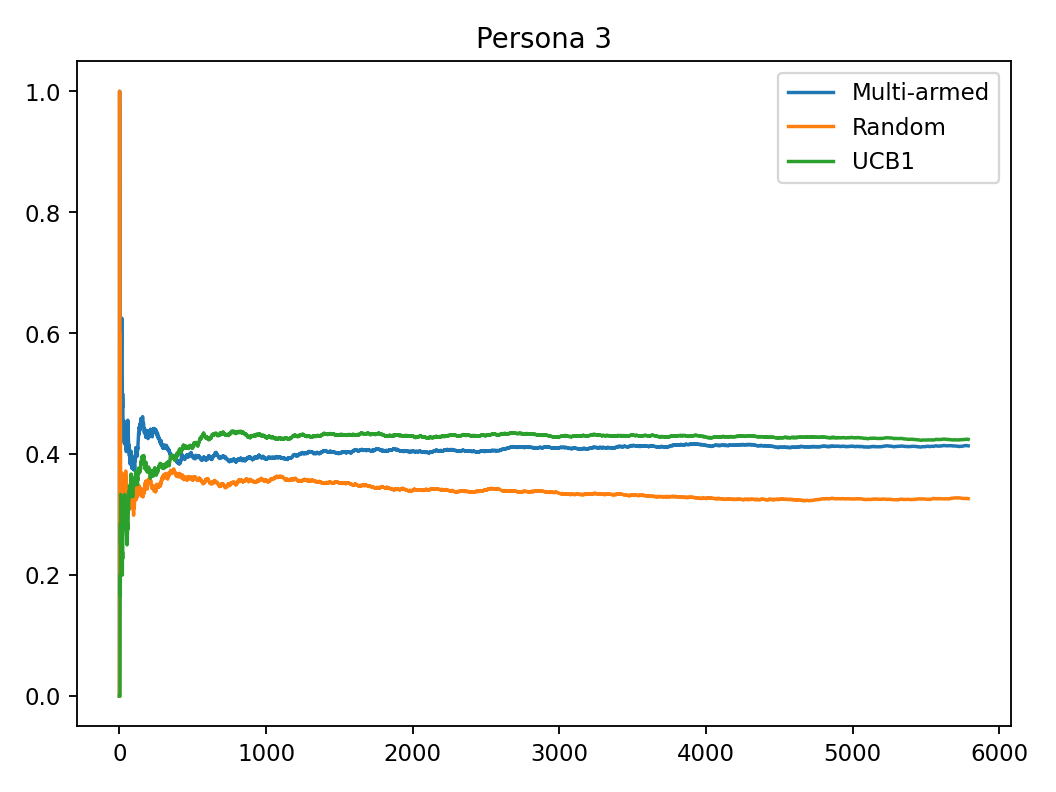

In [11]:
%matplotlib notebook

plt.plot(rewards[2])
plt.plot(rewards_random[2])
plt.plot(rewardsUCB[2])
plt.title('Persona 3')
    
plt.legend(['Multi-armed','Random','UCB1'])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


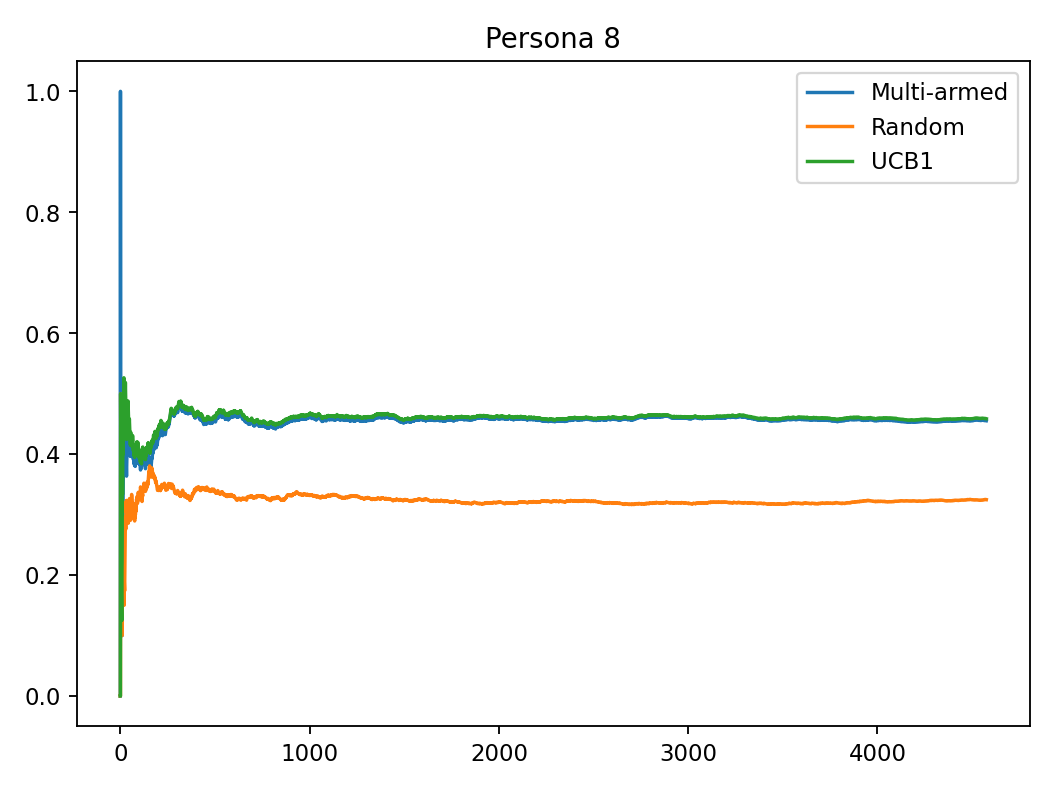

In [8]:
%matplotlib notebook

plt.plot(rewards[7])
plt.plot(rewards_random[7])
plt.plot(rewardsUCB[7])
plt.title('Persona 8')
    
plt.legend(['Multi-armed','Random','UCB1'])
plt.tight_layout()
plt.show()

In [9]:
print("Arm pulled by:\nThompson\tUCB1")
for persona in range(0,8):
    print(np.squeeze(np.where(np.unique(pullThompson[persona],return_counts=True)[1]==np.amax(np.unique(pullThompson[persona],return_counts=True)[1]))),"\t\t",np.squeeze(np.where(np.unique(pullUCB1[persona],return_counts=True)[1]==np.amax(np.unique(pullUCB1[persona],return_counts=True)[1]))))
print("\n0 = Storytelling\t1 = Peer comparison\t2 = Framing")

Arm pulled by:
Thompson	UCB1
0 		 0
1 		 1
2 		 2
2 		 2
0 		 0
1 		 1
0 		 0
1 		 1

0 = Storytelling	1 = Peer comparison	2 = Framing
